In [53]:
from google.colab import files
uploaded = files.upload()

Saving billboard_top.csv to billboard_top (1).csv


In [54]:
from google.colab import files
uploaded = files.upload()

Saving spotify_top_2024.csv to spotify_top_2024 (1).csv


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [56]:
spotify = pd.read_csv('spotify_top_2024.csv', encoding='latin1')
billboard = pd.read_csv('billboard_top.csv', encoding='latin1')

print("Spotify Columns:", spotify.columns.tolist())
print("Billboard Columns:", billboard.columns.tolist())

Spotify Columns: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity', 'Explicit Track']
Billboard Columns: ['chart_week', 'current_week', 'title', 'performer', 'last_week', 'peak_pos', 'wks_on_chart']


In [57]:
spotify.columns = spotify.columns.str.lower().str.strip()
billboard.columns = billboard.columns.str.lower().str.strip()

# Rename Spotify columns for consistency
spotify = spotify.rename(columns={
    'track': 'title',
    'artist': 'performer'
})

# Standardize text columns
for df in [spotify, billboard]:
    for col in ['title', 'performer']:
        df[col] = df[col].astype(str).str.lower().str.strip()

In [68]:
# Ensure chart_week is a datetime column
billboard['chart_week'] = pd.to_datetime(billboard['chart_week'], errors='coerce')

# Extract the year from the date
billboard['year'] = billboard['chart_week'].dt.year

# Filter to keep only songs that appeared on Billboard in 2024
billboard_2024 = billboard[billboard['year'] == 2024].copy()

In [67]:
merged = pd.merge(
    spotify,
    billboard_2024[['title', 'performer', 'peak_pos', 'wks_on_chart']],
    on=['title', 'performer'],
    how='inner'  # only keep songs that appear in both
)

In [69]:
features = [
    'spotify streams', 'spotify playlist count', 'spotify playlist reach',
    'spotify popularity', 'youtube views', 'youtube likes',
    'tiktok posts', 'tiktok likes', 'tiktok views'
]

# Clean numeric columns
for col in features:
    if col in merged.columns:
        merged[col] = (
            merged[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .str.replace('-', '0', regex=False)
            .str.extract('(\d+\.?\d*)')[0]
            .astype(float)
        )

# Create scaled version for plotting
merged['spotify_streams_100m'] = merged['spotify streams'] / 100_000_000

# Drop NaNs
merged = merged.dropna(subset=features + ['spotify_streams_100m', 'peak_pos'])

merged[features].describe()

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2886193718.py:15: SyntaxWarning: invalid escape sequence '\d'
  .str.extract('(\d+\.?\d*)')[0]


,spotify streams,spotify playlist count,spotify playlist reach,spotify popularity,youtube views,youtube likes,tiktok posts,tiktok likes,tiktok views
count,7.400000e+02,740.000000,7.400000e+02,740.000000,7.400000e+02,7.400000e+02,7.400000e+02,7.400000e+02,7.400000e+02
mean,5.186379e+08,57263.287838,8.358388e+07,75.663514,1.053981e+08,1.105083e+06,8.304959e+05,1.291203e+08,1.432825e+09
std,4.856672e+08,51088.765395,7.033496e+07,17.432849,1.479874e+08,1.458194e+06,1.570160e+06,2.107068e+08,2.436161e+09
min,1.029272e+07,1666.000000,3.644016e+06,2.000000,5.174500e+04,4.110000e+02,1.740000e+02,4.057000e+03,3.820000e+04
25%,1.702003e+08,17900.000000,1.385020e+07,73.000000,2.775878e+07,2.416410e+05,4.153875e+04,3.392242e+06,4.504770e+07
50%,3.505842e+08,32825.000000,7.071422e+07,80.000000,6.689388e+07,6.005510e+05,1.008930e+05,3.517607e+07,3.866100e+08
75%,7.501550e+08,98450.000000,1.504710e+08,85.000000,1.311481e+08,1.504385e+06,4.952000e+05,1.724381e+08,1.726707e+09
max,2.188247e+09,269802.000000,2.623434e+08,95.000000,1.096101e+09,1.062980e+07,1.889472e+07,1.432228e+09,1.596313e+10


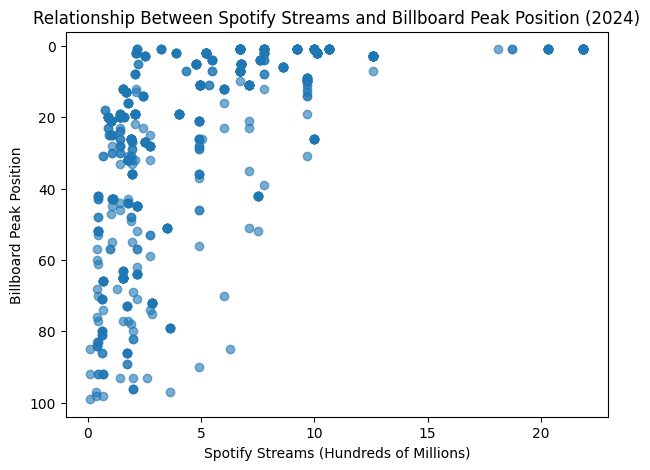

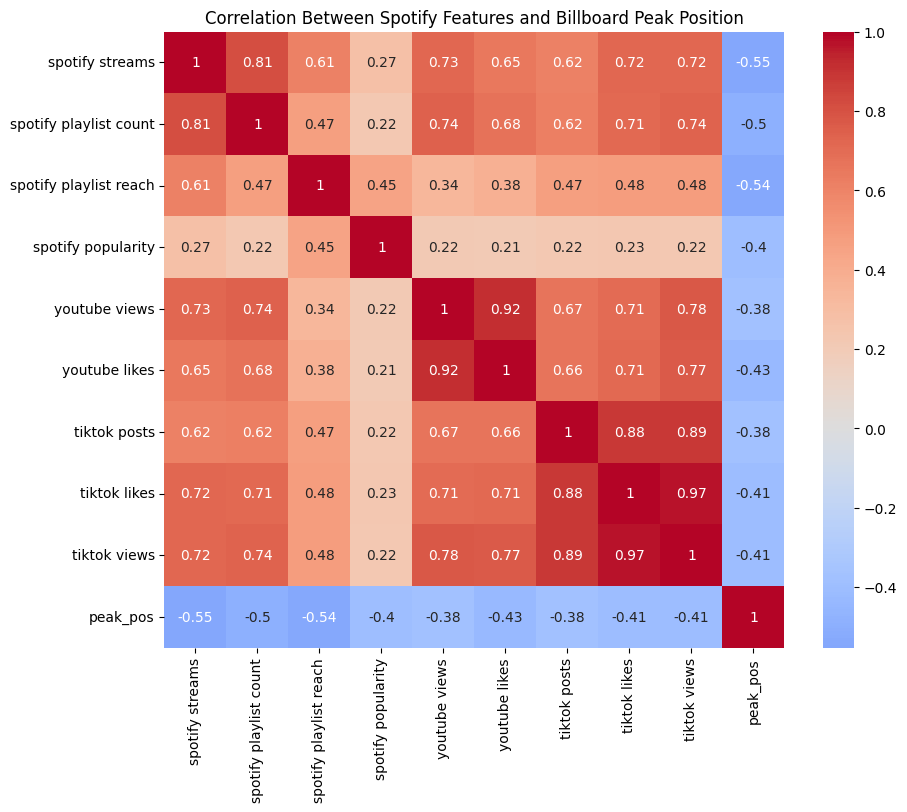

In [77]:
plt.figure(figsize=(7, 5))
plt.scatter(merged['spotify_streams_100m'], merged['peak_pos'], alpha=0.6)
plt.xlabel('Spotify Streams (Hundreds of Millions)')
plt.ylabel('Billboard Peak Position')
plt.title('Relationship Between Spotify Streams and Billboard Peak Position (2024)')
plt.gca().invert_yaxis()
plt.show()


corr = merged[features + ['peak_pos']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Spotify Features and Billboard Peak Position')
plt.show()


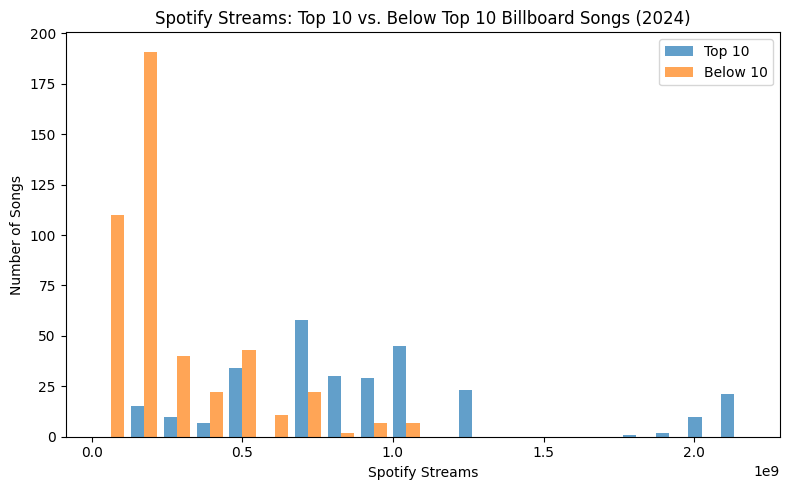

In [74]:
# Separate songs by chart performance
top10 = merged[merged['peak_pos'] <= 10]['spotify streams'].dropna()
below10 = merged[merged['peak_pos'] > 10]['spotify streams'].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist([top10, below10], bins=20, label=['Top 10', 'Below 10'], alpha=0.7)
plt.xlabel('Spotify Streams')
plt.ylabel('Number of Songs')
plt.title('Spotify Streams: Top 10 vs. Below Top 10 Billboard Songs (2024)')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
X = merged[features]
y = merged['peak_pos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

R² Score: 0.40652599712042536
Mean Absolute Error: 15.935152038277284


/tmp/ipython-input-261122721.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')


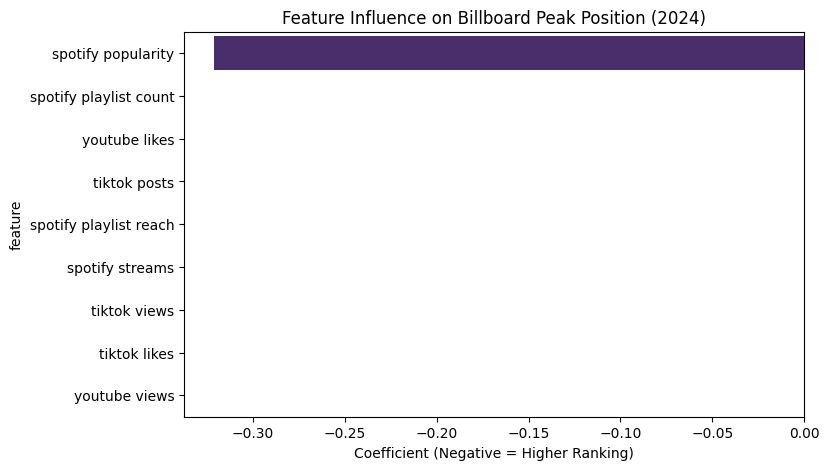

In [73]:
importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values(by='coefficient')

plt.figure(figsize=(8, 5))
sns.barplot(x='coefficient', y='feature', data=importance, palette='viridis')
plt.title('Feature Influence on Billboard Peak Position (2024)')
plt.xlabel('Coefficient (Negative = Higher Ranking)')
plt.show()